In [116]:
import torch
from torchvision.datasets import FashionMNIST
from torch.optim import Adam
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR
import math

## Setting

In [117]:
transform = Compose([ToTensor(), Normalize(0, 1), Resize((96, 96))])

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('use', device)

use cuda


In [119]:
# Hyper-parameter
epochs = 50
batch_size = 256

In [120]:
train_data = FashionMNIST('data', train=True, transform=transform, download=True)
test_data = FashionMNIST('data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)

## DenseNet

In [121]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channel, **kwargs):
        super().__init__(**kwargs)
        conv = [self.conv_block(num_channel) for _ in range(num_convs)]
        self.net = nn.Sequential(*conv)

    def conv_block(self, num_channel):
        return nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(), 
            nn.LazyConv2d(num_channel, kernel_size=3, padding=1)
        )
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)
        return X

In [122]:
def Transition_Block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(2, stride=2)
    )

In [123]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.start = nn.Sequential(
                    nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
                    nn.LazyBatchNorm2d(), nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                    )
        self.last = nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(), 
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), 
            nn.LazyLinear(10)
        )

        dense_block = []
        num_channels = 64
        num = 4
        for i, num_convs in enumerate([4] * num):
            dense_block.append(DenseBlock(num_convs, 32))
            num_channels += num_convs * 32

            if i != num - 1:
                num_channels //= 2
                dense_block.append(Transition_Block(num_channels))
        self.net = nn.Sequential(*dense_block)

    def forward(self, X):
        X = self.start(X)
        X = self.net(X)
        X = self.last(X)
        return X

In [124]:
model = Model(); model.to(device)
optimizer = Adam(model.parameters())
loss = CrossEntropyLoss()
scheduler = StepLR(optimizer, 5, math.exp(-0.1))

In [125]:
from torchsummary import summary
summary(model, (1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

## Start Training

In [126]:
history = {
    'acc':[],
    'loss':[],
    'val_acc':[],
    'val_loss':[],
}

In [127]:
def record(acc, loss, val_acc, val_loss, needPrint=False):
    global history
    history['acc'].append(acc)
    history['val_acc'].append(val_acc)
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    
    if needPrint:
        print(f'Training acc {acc:.4f}, loss {loss:.4f}')
        print(f'Test acc {val_acc:.4f}, loss {val_loss:.4f}')

In [128]:
last_val_acc = -1
best_val_acc = -1
count = 0
def EarlyStopping(patience=5, filepath='model.pt'):
    global history, model, last_val_acc, count, best_val_acc
    if best_val_acc < history['val_acc'][-1]:
        torch.save(model.state_dict(), filepath)
        print('\033[33m' + 'Save' + '\033[0m')
        best_val_acc = history['val_acc'][-1]
    else:
        if last_val_acc >= history['val_acc'][-1]: 
            count += 1    
        print('Not improved ' + '\033[38;5;236m' + 'Tu es nul :)' + '\033[0m')
        
    last_val_acc = history['val_acc'][-1]
        
    if count == patience: return True
    return False

In [129]:
for i in range(epochs):
    print(f'Epoch {i + 1} Start')
    
    model.train()
    train_acc = 0
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        img, label = data
        img, label = img.to(device), label.to(device)
        
        output = model(img)
        output_loss = loss(output, label)
        # Record
        train_acc += (output.argmax(dim=1) == label).sum().item()
        train_loss += output_loss.item()
        # BP
        output_loss.backward()
        optimizer.step()
    scheduler.step()
    train_acc /= len(train_data)
    train_loss /= len(train_loader)
    
    model.eval()
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            img, label = data
            img, label = img.to(device), label.to(device)
            
            output = model(img)
            output_loss = loss(output, label)
            # Record
            test_acc += (output.argmax(dim=1) == label).sum().item()
            test_loss += output_loss.item()
    
    test_acc /= len(test_data)
    test_loss /= len(test_loader)
    
    record(train_acc, train_loss, test_acc, test_loss, True)
    if EarlyStopping(10): break
    print('==================================')

Epoch 1 Start
Training acc 0.8387, loss 0.4594
Test acc 0.8318, loss 0.4642
Save
Epoch 2 Start
Training acc 0.9007, loss 0.2702
Test acc 0.8543, loss 0.4000
Save
Epoch 3 Start
Training acc 0.9129, loss 0.2340
Test acc 0.8623, loss 0.3657
Save
Epoch 4 Start
Training acc 0.9254, loss 0.2062
Test acc 0.8776, loss 0.3338
Save
Epoch 5 Start
Training acc 0.9310, loss 0.1893
Test acc 0.9146, loss 0.2228
Save
Epoch 6 Start
Training acc 0.9366, loss 0.1736
Test acc 0.9120, loss 0.2369
Not improved Tu es nul :)
Epoch 7 Start
Training acc 0.9407, loss 0.1600
Test acc 0.9278, loss 0.1963
Save
Epoch 8 Start
Training acc 0.9446, loss 0.1514
Test acc 0.9250, loss 0.2067
Not improved Tu es nul :)
Epoch 9 Start
Training acc 0.9478, loss 0.1403
Test acc 0.9223, loss 0.2237
Not improved Tu es nul :)
Epoch 10 Start
Training acc 0.9503, loss 0.1327
Test acc 0.9265, loss 0.2073
Not improved Tu es nul :)
Epoch 11 Start
Training acc 0.9555, loss 0.1194
Test acc 0.9254, loss 0.2159
Not improved Tu es nul :)
Ep

## Plot Outcome

In [130]:
def plot_perfomance(name):
    global device, history
    plt.plot(history[name], 'b', label='train')
    plt.plot(history['val_' + name], 'r', label='val')
    plt.title('Performance')
    plt.ylabel(name)
    plt.xlabel('Epoch')
    plt.show()

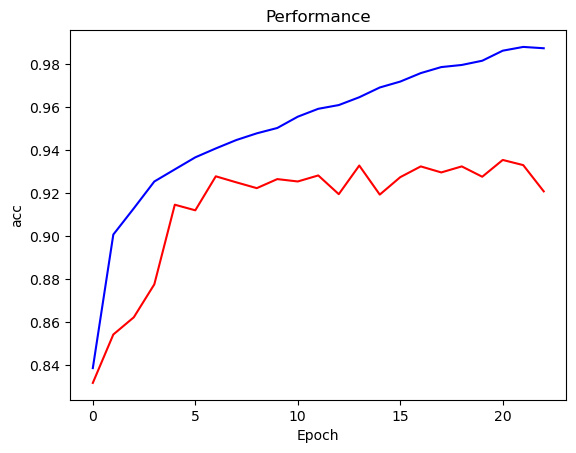

In [131]:
plot_perfomance('acc')

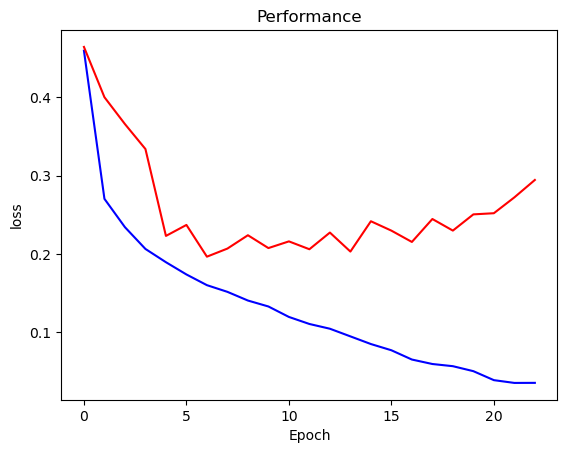

In [132]:
plot_perfomance('loss')

In [133]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

true_label = torch.tensor([], dtype=int)
pred_label = torch.tensor([], dtype=int)

model.eval()
for data in test_loader:
    img, label = data
    img, label = img.to(device), label.to(device)
    
    true_label = torch.cat((true_label, label.cpu().detach()))
    
    output = model(img).argmax(dim=1).cpu().detach()
    pred_label = torch.cat((pred_label, output))

In [134]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print('\033[33m' + 'Accuracy' + '\033[0m', round(accuracy_score(true_label, pred_label), 4))
print('\033[33m' + 'Classification Report' + '\033[0m')
print(classification_report(true_label, pred_label, target_names=[train_data.classes[i] for i in range(10)]))

Accuracy 0.9354
Classification Report
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.92      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.88      0.93      0.90      1000
       Dress       0.92      0.95      0.94      1000
        Coat       0.90      0.91      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.89      0.73      0.80      1000
     Sneaker       0.96      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.96      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.93     10000
weighted avg       0.94      0.94      0.93     10000



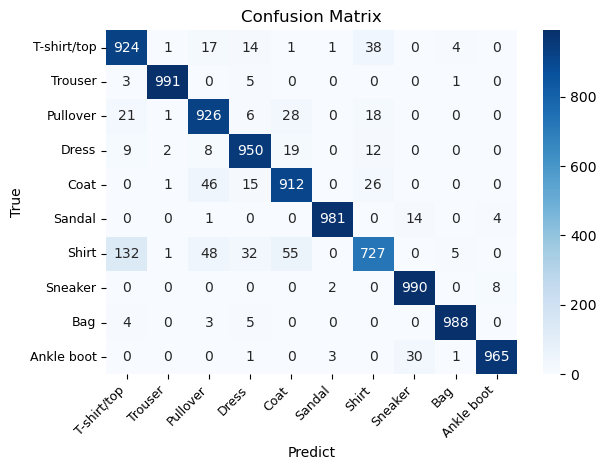

In [135]:
cm = confusion_matrix(true_label, pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predict')
plt.yticks([i + 0.5 for i in range(10)], [test_data.classes[i] for i in range(10)], rotation=0, fontsize=9)
plt.xticks([i + 0.5 for i in range(10)], [test_data.classes[i] for i in range(10)], rotation=45, ha='right', fontsize=9)
plt.tight_layout()
plt.show()